# Data Science Capstone Project

In [1]:
# The code was removed by Watson Studio for sharing.

Libaries used in this notebook are imported below.

In [2]:
import time
import json
import requests
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import foursquare
import folium
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN
from fuzzywuzzy import process

In [3]:
# The code was removed by Watson Studio for sharing.

The goal for this project is to combine two sets of data and determine which area would be the best location to build a new brewery. The underlying assumptions are that breweries, when clustered, become an attraction - and that breweries sell more beer if they're located close to a population that has a higher disposable income. At the root - these are my opinions and I'd love to explore them more in the future to see how correct (or incorrect) I might be.

To start this project I needed to figure out where "brewery districts" are currently located. Since the assumption is that the purpose of this exercise is to find a location to build a brewery, I defined the minimum number to be a "district" as 2, since 1 will theoretically be added at some future date.

When I started this project - I assumed the difficult part of the project was going to be applying data science principles to the relatively easily collected data from FourSquare. As it turns out, everything that everyone says about getting data cleaned and ready for processing was substanially more time intensive than the "data science" part.

When I started with FourSquare - I was extremely disappointed with the low number of results. As you'll see, I combined two different FourSquare results - and still don't really have that many. I unfortunately then had to go back and figure out how to integrate another data source into the project - which introduced a fun new data problem of removing duplicates across two different data sources that didn't quite line up - and it took me realizing that half of my clusters were clustered with themselves for me to realize I had this issue.

I ran two queries using the FourSquare API, the first was using the FourSquare category for brewery which is 50327c8591d4c4b30a586d5d, and second was simply the search term "brewery". I opted to center the project around where I live in Odenton, MD which is convientienty right between Washington DC and Baltimore.

Below you can see my API call using the FourSquare Python wrapper. In order to make the data usable, I took the JSON file which was generated from the call and imported it into a pandas DataFrame.


In [4]:
breweries=client.venues.search(params={'intent':'browse','categoryId': '50327c8591d4c4b30a586d5d', 'near': 'Odenton, MD','radius':'50000'})
breweries_2=client.venues.search(params={'intent':'browse','query': 'brewery', 'near': 'Odenton, MD','radius':'50000'})
b_df=json_normalize(breweries['venues'])
b_df_2=json_normalize(breweries_2['venues'])
b_df_2.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",False,5207aa8111d28afd3b21cf3f,300 Tingey St SE,US,Washington,United States,at 4th St SE,"[300 Tingey St SE (at 4th St SE), Washington, ...","[{'label': 'display', 'lat': 38.87516890554908...",38.875169,-77.000773,20003,D.C.,Bluejacket Brewery,v-1591586388,84401049
1,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",False,4ae778fff964a520a9ab21e3,6695 Dobbin Rd,US,Columbia,United States,NaN,"[6695 Dobbin Rd, Columbia, MD 21045, United St...","[{'label': 'display', 'lat': 39.18608142934597...",39.186081,-76.825249,21045,MD,Frisco Tap House & Brewery,v-1591586388,NaN
2,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",False,5081aa47e4b052836fbc50b8,401 E 30th St,US,Baltimore,United States,at Barclay St,"[401 E 30th St (at Barclay St), Baltimore, MD ...","[{'label': 'display', 'lat': 39.32474411733325...",39.324744,-76.610819,21218,MD,Peabody Heights Brewery,v-1591586388,NaN
3,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",False,4a981c4af964a520842a20e3,3625 Jefferson Davis Hwy,US,Alexandria,United States,NaN,"[3625 Jefferson Davis Hwy, Alexandria, VA 2230...","[{'label': 'display', 'lat': 38.83745951494611...",38.837460,-77.051224,22305,VA,Hops Grill & Brewery,v-1591586388,NaN
4,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",False,59d9f5a0396de00ee39e1f7a,2408 Crofton Blvd,US,Crofton,United States,NaN,"[2408 Crofton Blvd, Crofton, MD 21114, United ...","[{'label': 'display', 'lat': 39.015797, 'lng':...",39.015797,-76.698748,21114,MD,Chesepiooc Real Ale Brewery,v-1591586388,NaN


As you can see - 48 breweries doesn't really seem like that low of a number - until you start to look at all of the breweries that are missing and a lot of potential clusters.

In [5]:
b_df=pd.concat((b_df,b_df_2), axis=0,sort=True)
b_df.drop_duplicates('name',keep=False,inplace=True)
b_df['name'].count()

48

I decided to go with the Google Maps Places API to hopefully fill in my data a bit more. I started off with the googlemaps Python library and felt sucessful quickly - until I realized that they were limited to only 20 results, and inside that library there is no functionality to obtain more results. I discovered it was possible to get as many as 60 results using "pagetokens" which took me far too long to determine how to use them. As you'll notice, they require a waiting period between calls since the tokens they provide to access the next page of results are not immediately valid. After this step I combine my three sets of results in a pandas DataFrame.

In [6]:
url = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query=brewery&radius=50000&location=39.083988, -76.700250&key=' + api_key
response = requests.get(url)
response_json = response.json()
next_page_token=response_json['next_page_token']
time.sleep(5)
url = 'https://maps.googleapis.com/maps/api/place/textsearch/json?key=' + api_key + '&pagetoken='+ next_page_token
response2 = requests.get(url)
response_json2 = response2.json()
next_page_token=response_json2['next_page_token']
time.sleep(5)
url = 'https://maps.googleapis.com/maps/api/place/textsearch/json?key=' + api_key + '&pagetoken='+ next_page_token
response3 = requests.get(url)
response_json3 = response3.json()

In [7]:
g_df1=json_normalize(response_json['results'])
g_df2=json_normalize(response_json2['results'])
g_df3=json_normalize(response_json3['results'])
g_df=pd.concat([g_df1,g_df2,g_df3],ignore_index=True, sort=True)
g_df.head()

,business_status,formatted_address,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,icon,id,...,permanently_closed,photos,place_id,plus_code.compound_code,plus_code.global_code,price_level,rating,reference,types,user_ratings_total
0,OPERATIONAL,"2709 S Oakland St, Arlington, VA 22206, United...",38.843663,-77.089647,38.845051,-77.088457,38.842352,-77.091156,https://maps.gstatic.com/mapfiles/place_api/ic...,b0a854143e896e7af384224623bebb1116ad5980,...,NaN,"[{'height': 1152, 'html_attributions': ['<a hr...",ChIJu7hKOE6xt4kRmfbBUMYzuuE,"RWV6+F4 Arlington, Virginia",87C4RWV6+F4,NaN,4.3,ChIJu7hKOE6xt4kRmfbBUMYzuuE,"[food, point_of_interest, establishment]",159
1,OPERATIONAL,"8401 Colesville Rd #150, Silver Spring, MD 209...",38.994982,-77.031223,38.996434,-77.029831,38.993735,-77.032531,https://maps.gstatic.com/mapfiles/place_api/ic...,e355249111777d9c1559444c40473e9b15176e9c,...,NaN,"[{'height': 2321, 'html_attributions': ['<a hr...",ChIJ4X8JCajJt4kR_Wf6XNG47tA,"XXV9+XG Silver Spring, Maryland",87C4XXV9+XG,NaN,4.7,ChIJ4X8JCajJt4kR_Wf6XNG47tA,"[cafe, bar, liquor_store, restaurant, food, po...",126
2,OPERATIONAL,"3950 Wheeler Ave, Alexandria, VA 22304, United...",38.807959,-77.101423,38.809397,-77.099925,38.806697,-77.102625,https://maps.gstatic.com/mapfiles/place_api/ic...,d82f67a88713f24d6fa85347c0cb3ac0b40418eb,...,NaN,"[{'height': 2358, 'html_attributions': ['<a hr...",ChIJJarEi4Cxt4kRk4BFKHDhOnM,"RV5X+5C Alexandria, Virginia",87C4RV5X+5C,NaN,4.7,ChIJJarEi4Cxt4kRk4BFKHDhOnM,"[food, point_of_interest, establishment]",423
3,OPERATIONAL,"912 Washington Blvd, Baltimore, MD 21230, Unit...",39.283111,-76.631510,39.284347,-76.630127,39.281647,-76.632826,https://maps.gstatic.com/mapfiles/place_api/ic...,39e2b28a1021c7818936641b150c846eaebb6c9b,...,NaN,"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJV34H5ITNt4kR5oZSLiDFR2M,"79M9+69 Baltimore, Maryland",87F579M9+69,NaN,4.8,ChIJV34H5ITNt4kR5oZSLiDFR2M,"[food, point_of_interest, establishment]",167
4,OPERATIONAL,"15850 Commerce Ct, Upper Marlboro, MD 20774, U...",38.886462,-76.730947,38.887812,-76.729383,38.885113,-76.732082,https://maps.gstatic.com/mapfiles/place_api/ic...,8f1b4394bab45bfafeb7e28855ff57b09cc950c9,...,NaN,"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJgf7KYlaTt4kRZRiwk2iUHnY,"V7P9+HJ Upper Marlboro, Maryland",87C5V7P9+HJ,NaN,4.6,ChIJgf7KYlaTt4kRZRiwk2iUHnY,"[liquor_store, food, point_of_interest, store,...",121


In [8]:
g_df['name'].count()

60

The clearest demonstration of why this was necessary is shown below. The FourSquare results are depicted in blue, and the Google in green.

In [9]:
m = folium.Map(location=[39.097087,-76.694132],
              zoom_start = 10)

latitudes = list(b_df['location.lat'])
longitudes = list(b_df['location.lng'])
labels = list(b_df['name'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
      location = [lat, lng], 
      popup = label,
      icon = folium.Icon(color='blue', icon='info-sign')
     ).add_to(m)
    
latitudes = list(g_df['geometry.location.lat'])
longitudes = list(g_df['geometry.location.lng'])
labels = list(g_df['name'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
      location = [lat, lng], 
      popup = label,
      icon = folium.Icon(color='green', icon='info-sign')
     ).add_to(m)
    
m

The next step is to combine the results from both sources, which means removing duplicate entries. I attempted to remove them with the simplest way I could think of, which was df.drop_duplicates(, but alas that once works for cells that have identical entries. Not strings that randomly swap between Brewing and Brewery or Company and Co.  As I struggled to think about how I was going to accomplish this, I came across the FuzzyWuzzy package, which didn't necessarily have a clear implementation for this process - I did eventually find a way to accomplish it. FuzzyWuzzy essentially give you a number that tells you how similar two strings are by how many characters would need to be changed for one to become the other one using the Levenshtein Distance. My method was borrowed from another - but it allows you to compare a single string to a list of strings - and will assign a numerical ranking. Since the Google list was a bit longer and apparently more robust - I opted to compare each name in the FourSquare results to the Google result and filter out all of the results that had a score higher than 86.  I realized that I also needed to include some pre-processing of lists for this purpose to remove all of the stop words for this task, such as Brewery or Brewing.

This process worked well - I went back through the list at the end and manually removed a few more - one example was a Brewery Tours company - which was not the intent.

In [10]:
g_form=g_df[['name','geometry.location.lat','geometry.location.lng']]
g_form.columns=['name','lat','lng']
b_form=b_df[['name','location.lat','location.lng']]
b_form.columns=['name','lat','lng']

In [11]:
def duplicate_finder(name):
    duplicate, score = process.extractOne(name.replace("Brewery","").replace("Brewing","").replace("Co","").replace("Company","").replace("Tavern",""), 
                                          list(g_form['name'].str.replace("Brewery|Brewing|Co|Company|Tavern|Production","")))[0:2]
    if score > 86:
        return 'True', score
    else:
        return 'False', score

Below is an example of whether or not the data was considered a match.

In [12]:
b_form['duplicate'], b_form['duplicate_score'] = zip(*b_form['name'].apply(duplicate_finder))
b_form_scrub=b_form[b_form['duplicate']=='False'].sort_values(by=['name'])
b_form_scrub=b_form_scrub[['name','lat','lng']]
b_form.sort_values(by=['name']).head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,name,lat,lng,duplicate,duplicate_score
21,American Brewery Building,39.309479,-76.587371,False,60
5,Aslin Beer Company,38.804217,-77.138253,True,100
12,Astro Lab Brewery,38.992113,-77.026890,True,100
15,Athenzzz Brewery,39.103444,-76.808039,False,43
7,Bare Bones Grill & Brewery,39.277721,-76.828146,False,56


As you can see below - the final list ended up being not quite double the original number - but provided an important enhancement of the quality of the data.

In [13]:
all_df=pd.concat([g_form,b_form_scrub],ignore_index=True, sort=True)
all_df.drop_duplicates('name',keep=False,inplace=True)
all_df=all_df[~all_df.name.str.contains('Tour|Tours|Commons|Trading|Brookland|GUILD')]
all_df=all_df.sort_values(by=['name'])
all_df.count()

lat     84
lng     84
name    84
dtype: int64

Now that we have our list we finally get to move to the clustering stage of the project - since it's clustering based on physical locations the process is extremely straightforward. Below is a depiction of all of the breweries on a bit simpler plot.

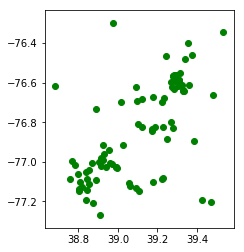

In [14]:
gdf = geopandas.GeoDataFrame(
    all_df['name'], geometry=geopandas.points_from_xy(all_df['lat'], all_df['lng']))

gdf.plot(color='green')

plt.show()

I opted to use DBSCAN to cluster the breweries since it is very straightforward to use real world sizes to govern this process. I selected the maximum distance apart for two breweries to be 2km, and used the 'ball_tree' algorithim, and 'havesine' metric to keep it aligned to the real world parameter of 2km. When complete, there are 14 clusters.

In [36]:
coords = all_df.as_matrix(columns=['lat', 'lng'])

kms_per_radian = 6371.0088
epsilon = 2 / kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
data=pd.concat([pd.DataFrame(all_df.as_matrix(columns=['name','lat', 'lng'])), pd.DataFrame(cluster_labels)], axis=1)
data.columns=["name", "lat","lon","cluster_label"]
data.head()

Number of clusters: 14


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,name,lat,lon,cluster_label
0,3 Stars Brewing Company,38.9675,-77.0126,0
1,7 Locks Brewing,39.056,-77.1102,1
2,AleCraft Brewery,39.5337,-76.3458,-1
3,American Brewery Building,39.3095,-76.5874,2
4,Aslin Beer Company,38.8041,-77.1382,3


Below is the same plot, but with clusters labeled by different colors. As you can see, the '-1' label is extraordinarily prevalent. This is because these are all of the unclusterd breweries.

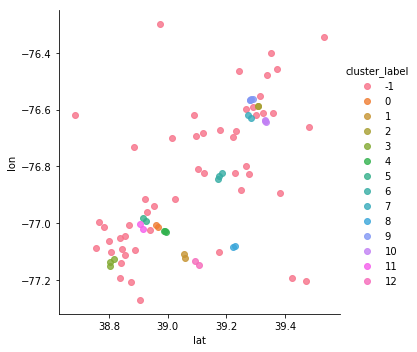

In [17]:
facet = sns.lmplot(data=data, x='lat', y='lon', hue='cluster_label', 
                   fit_reg=False, legend=True, legend_out=True)

To be able to easily see the clusters, we need to remove the unclustered breweries, you can see this below.

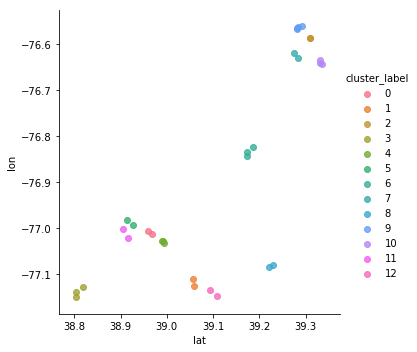

In [18]:
data_scrub=data.drop(data[data['cluster_label'] == -1].index)
facet = sns.lmplot(data=data_scrub, x='lat', y='lon', hue='cluster_label', 
                   fit_reg=False, legend=True, legend_out=True)

If you've stuck with me this far - you would probably love to see the different potential 'districts' that I've shown. Here they are.

In [19]:
data_scrub=data_scrub.sort_values(by=['cluster_label'])
data_scrub=data_scrub.reset_index(drop=True)
data_scrub

,name,lat,lon,cluster_label
0,3 Stars Brewing Company,38.9675,-77.0126,0
1,Hellbender Brewing Company,38.9604,-77.0052,0
2,7 Locks Brewing,39.056,-77.1102,1
3,Cho Family Brewery,39.0591,-77.1246,1
4,American Brewery Building,39.3095,-76.5874,2
5,Humanim At The American Brewery,39.3094,-76.5874,2
6,Aslin Beer Company,38.8041,-77.1382,3
7,Ruszkie's Bar And Brewery,38.8045,-77.1502,3
8,Dan's Brewery,38.8178,-77.1277,3
9,Silver Branch Brewing Company,38.995,-77.0312,4


The follow on to these clusters is to rank them based on the housing values nearby. I took the housing data from https://www.zillow.com/research/data/, my method is to simply find the center point between the two (or more) breweries and determine the zip code of that point.

In [20]:
df_housing=pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Sale_Prices_Zip.csv")

Here is a quick peak at the necessary pieces of that information from the .csv.

In [21]:
df_housing[['RegionName','2020-03']].head()

,RegionName,2020-03
0,10025,1007900.0
1,60657,411500.0
2,10023,1107500.0
3,77494,331700.0
4,60614,509800.0


As explained above, this ends up being a two step process. 1. Locate the center point, as shown below.

In [22]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

2. Lookup the zipcode for that location and then match that zip code to the median value in the Zillow Housing data frame.

In [37]:
locator = Nominatim(user_agent="myGeocoder")

def zip_code_coder(row):
    location = locator.reverse(centermost_points[row])
    return location.address.split(",")[-2]

cluster_zips = pd.DataFrame([zip_code_coder(n) for n in range(len(centermost_points))])
cluster_zips.columns=['zip']
cluster_zips=cluster_zips.astype(int)
cluster_zips=cluster_zips.astype(int)
cluster_zips['cluster']=cluster_zips.index
cluster_zips.head()
inner_join = pd.merge(df_housing[['RegionName','2020-03']],
                      cluster_zips,
                      left_on ='RegionName',
                      right_on='zip') 
inner_join.drop(columns='zip',inplace=True)
inner_join.columns=['zip','median_value','cluster']
inner_join.sort_values(by='median_value', ascending=False)

,zip,median_value,cluster
0,20011,628500.0,0
7,20017,514500.0,5
4,20910,499800.0,4
9,20855,496600.0,12
2,20852,461100.0,1
1,22304,366400.0,3
8,21046,349500.0,6
6,21211,217800.0,10
5,21230,213900.0,7
3,21224,190200.0,9


The final results are listed below - based on March 2020 median values are listed below.

In [41]:
print("The most lucrative location for building a brewery is the area that surrounds ",list(data_scrub.loc[data_scrub['cluster_label']==0]['name']))

The most lucrative location for building a brewery is the area that surrounds  ['3 Stars Brewing Company', 'Hellbender Brewing Company']


In [40]:
print("The 2nd most lucrative location for building a brewery is the area that surrounds ",list(data_scrub.loc[data_scrub['cluster_label']==5]['name']))

The 2nd most lucrative location for building a brewery is the area that surrounds  ['Atlas Brew Works', 'Right Proper Brewing']


In [39]:
print("The 3rd most lucrative location for building a brewery is the area that surrounds ",list(data_scrub.loc[data_scrub['cluster_label']==4]['name']))

The 3rd most lucrative location for building a brewery is the area that surrounds  ['Silver Branch Brewing Company', 'Denizens Brewing Co.', 'Astro Lab Brewing']


In [38]:
print("The 4th most lucrative location for building a brewery is the area that surrounds ",list(data_scrub.loc[data_scrub['cluster_label']==12]['name']))

The 4th most lucrative location for building a brewery is the area that surrounds  ['Saints Row Brewing', 'True Respite Brewing Company']
